# Optimize MOOC learner pathways

In this section, we propose a learning item recommendation system based on
consensus clustering (MultiCons) and collaborative filtering.

The approach consists of first grouping learners into homogeneous groups based on
their profile and learning activities in the course using consensus clustering.

Then, for each student cluster, collaborative filtering is applied to recommend
previously unexplored learning items.

We measure the quality of our approach by first training a decision tree classifier
predicting certification success, then comparing changes in success predictions when
students whose failure had previously been correctly predicted follow the
recommendations.

Finally, we compare the quality of our approach to a baseline method that applies
collaborative filtering on the full dataset.

In [3]:
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering, Birch, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from surprise import Dataset, KNNWithMeans, Reader
from surprise.model_selection import GridSearchCV as SupGridSearchCV

from multicons import MultiCons

from oulad import filter_by_module_presentation, get_oulad

## Preparing the dataset

In this section we:
 - Load the OULAD dataset
 - Select a subset related to a course session
 - Prepare the student interaction and student profile feature tables

### Loading OULAD

In [4]:
oulad = get_oulad()

### Selecting one course session

We start by selecting one OULAD course session.

We choose the `BBB` course from the `2013J` session.

In [5]:
CODE_MODULE = "BBB"
CODE_PRESENTATION = "2013J"

#### The `student_item` table

It represents all student interactions with course items of the selected course
session.

In [6]:
student_item = (
    filter_by_module_presentation(oulad.student_vle, CODE_MODULE, CODE_PRESENTATION)
    .drop(["date"], axis=1)
    .groupby(["id_site", "id_student"])
    .sum()
    .reset_index()
    # We convert the `id_site` column to string type as the values of `id_site` will
    # be used as column names in the `student_profile` table.
    # student_item.id_site = student_item.id_site.astype(str)
    .astype({"id_site": str})
)
display(student_item)

,id_site,id_student,sum_click
0,703721,23798,169
1,703721,27759,123
2,703721,30091,229
3,703721,31014,130
4,703721,31849,336
...,...,...,...
67526,704240,2400851,2
67527,704240,2464683,2
67528,704240,2512392,1
67529,704240,2638818,1


#### The `student_profile` table

It contains student demographic data along with course registration information,
course item interactions, and the final result.

It also lets us identify students that have no interaction records or have
unregistered before the course started, which we exclude.

We consider students marked with a final result of `Withdrawn` and `Fail` as failed
and students marked with `Pass` or `Distinction` as succeded.

In [7]:
student_info = (
    filter_by_module_presentation(oulad.student_info, CODE_MODULE, CODE_PRESENTATION)
    .set_index("id_student")
    .drop(["num_of_prev_attempts", "region"], axis=1)
)
student_registration = (
    filter_by_module_presentation(
        oulad.student_registration, CODE_MODULE, CODE_PRESENTATION
    )
    .set_index("id_student")
    # Remove students that unregistered before the course started.
    .query("~(date_unregistration < 0)")
    .drop(["date_unregistration"], axis=1)
)
student_registration_info = student_registration.join(student_info, how="inner")

student_activity = student_item.pivot_table(
    values="sum_click",
    index="id_student",
    columns="id_site",
    fill_value=0.0,
)

# Remove students that have no interaction records.
student_activity = student_activity.loc[:, (student_activity != 0).any(axis=0)]

student_profile = student_registration_info.join(student_activity, how="inner")

display(student_profile)

,date_registration,gender,highest_education,imd_band,age_band,studied_credits,disability,final_result,703721,703722,...,704231,704232,704233,704234,704235,704236,704237,704238,704239,704240
id_student,,,,,,,,,,,,,,,,,,,,,
23798,-27.0,M,A Level or Equivalent,50-60%,0-35,60,N,Distinction,169,6,...,0,0,0,0,0,0,0,0,0,0
27759,-43.0,M,Lower Than A Level,40-50%,35-55,120,Y,Fail,123,7,...,0,0,0,0,0,0,0,0,0,0
30091,-145.0,F,A Level or Equivalent,10-20,0-35,60,Y,Pass,229,34,...,0,0,0,0,0,0,0,0,0,0
31014,-43.0,F,Lower Than A Level,80-90%,35-55,120,N,Withdrawn,130,65,...,0,0,0,0,0,0,0,0,0,0
31849,-128.0,F,Lower Than A Level,60-70%,35-55,120,N,Pass,336,24,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680344,-25.0,F,HE Qualification,80-90%,35-55,60,N,Pass,396,31,...,0,0,0,0,1,0,0,0,0,0
2680885,-141.0,F,Lower Than A Level,50-60%,0-35,60,Y,Distinction,28,5,...,0,0,0,0,0,0,0,0,0,0
2691100,-141.0,F,Lower Than A Level,0-10%,0-35,120,N,Pass,245,3,...,0,0,0,0,0,0,0,0,0,0


#### The `encoded_student_profile` table.

Finally, we encode all ordinal categorical values from the `student_profile` table
into the `encoded_student_profile` table.

In [9]:
encoded_student_profile = student_profile.copy()

ordinal_values_maps = {
    "age_band": {"0-35": 0, "35-55": 0.5, "55<=": 1},
    "disability": {"N": 0, "Y": 1},
    "gender": {"M": 0, "F": 1},
    "highest_education": {
        "No Formal quals": 0,
        "Lower Than A Level": 0.25,
        "A Level or Equivalent": 0.5,
        "HE Qualification": 0.75,
        "Post Graduate Qualification": 1,
    },
    "imd_band": {
        np.nan: 0,
        "0-10%": 5,
        "10-20": 15,
        "20-30%": 25,
        "30-40%": 35,
        "40-50%": 45,
        "50-60%": 55,
        "60-70%": 65,
        "70-80%": 75,
        "80-90%": 85,
        "90-100%": 95,
    },
    "final_result": {"Withdrawn": 0, "Fail": 0, "Pass": 1, "Distinction": 1},
}

for col, values_map in ordinal_values_maps.items():
    encoded_student_profile.loc[:, col] = encoded_student_profile.loc[:, col].map(
        values_map
    )

encoded_student_profile = encoded_student_profile.astype(float)
display(encoded_student_profile)

,date_registration,gender,highest_education,imd_band,age_band,studied_credits,disability,final_result,703721,703722,...,704231,704232,704233,704234,704235,704236,704237,704238,704239,704240
id_student,,,,,,,,,,,,,,,,,,,,,
23798,-27.0,0.0,0.50,55.0,0.0,60.0,0.0,1.0,169.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27759,-43.0,0.0,0.25,45.0,0.5,120.0,1.0,0.0,123.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30091,-145.0,1.0,0.50,15.0,0.0,60.0,1.0,1.0,229.0,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31014,-43.0,1.0,0.25,85.0,0.5,120.0,0.0,0.0,130.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31849,-128.0,1.0,0.25,65.0,0.5,120.0,0.0,1.0,336.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680344,-25.0,1.0,0.75,85.0,0.5,60.0,0.0,1.0,396.0,31.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2680885,-141.0,1.0,0.25,55.0,0.0,60.0,1.0,1.0,28.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2691100,-141.0,1.0,0.25,5.0,0.0,120.0,0.0,1.0,245.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train/Test split

In this section we split the `encoded_student_profile` table into training and
testing sets.

In [10]:
RANDOM_STATE = 0
feature_table = encoded_student_profile.drop(["final_result"], axis=1)
result_table = encoded_student_profile.loc[:, ["final_result"]]
x_train, x_test, y_train, y_test = train_test_split(
    feature_table, result_table, test_size=0.2, random_state=RANDOM_STATE
)

student_vle_train = student_item.loc[student_item.id_student.isin(y_train.index)]
student_vle_test = student_item.loc[student_item.id_student.isin(y_test.index)]

## Final result prediction

Next, we train a decision tree model to predict the student `final_result` outcome.
The model will be used at the final step to evaluate the quality of the
recommendations.

'score=0.8903'

"best_parameters={'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 13, 'random_state': 0, 'splitter': 'best'}"

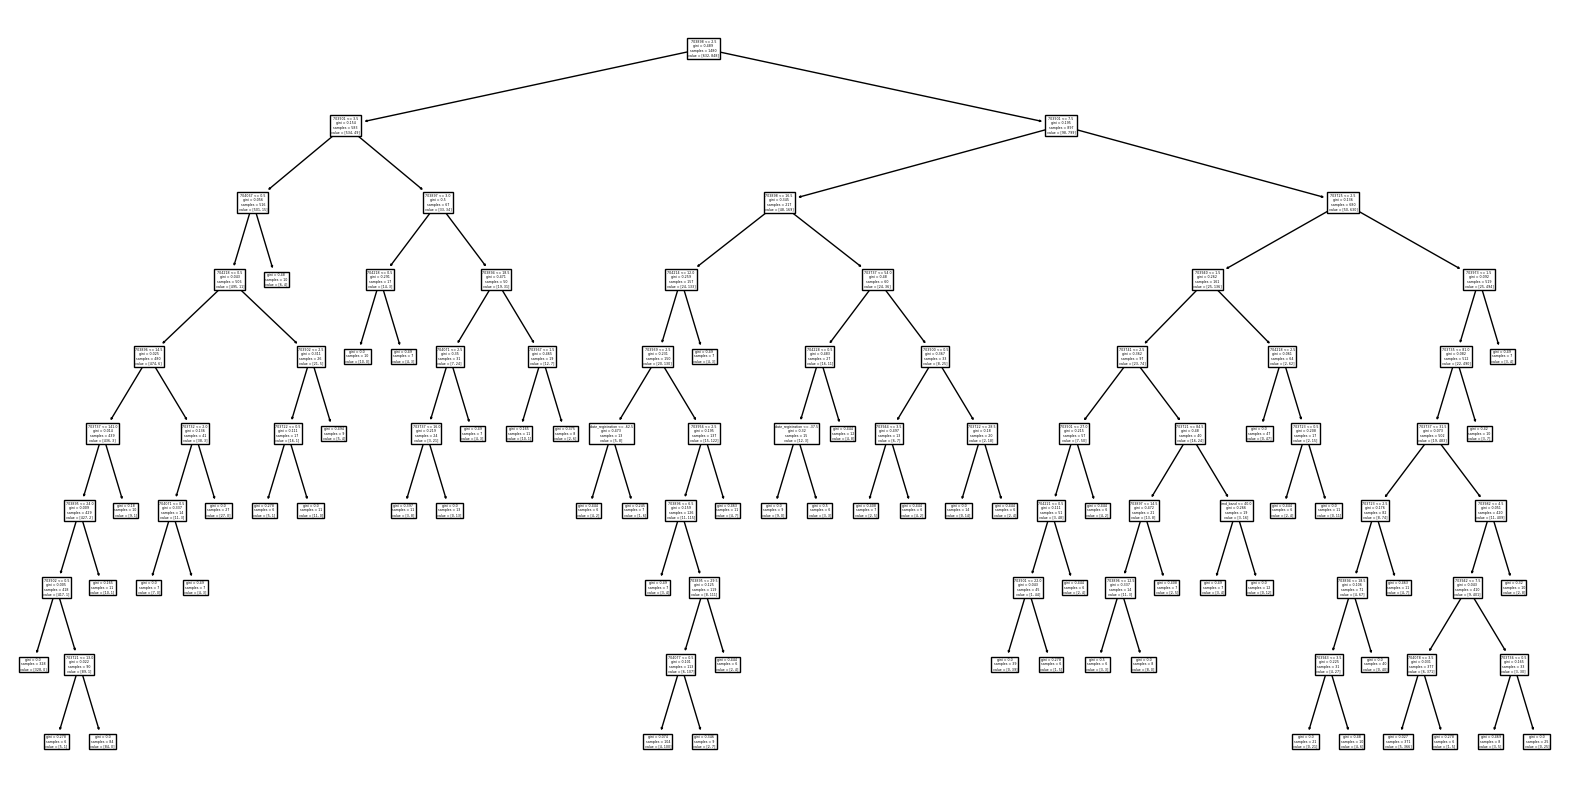

'Out of 147 failing students, the model predicted correctly 121 students (82.31%).'

In [14]:
# Hyperparameter search space
hyperparameters = {
    "criterion": ["gini"],  # ["gini", "entropy", "log_loss"],
    "splitter": ["best"],  # ["random", "best"],
    "max_depth": [9],  # [None, *list(range(1, 20))],
    "min_samples_split": [13],  # range(2, 20),
    "min_samples_leaf": [6],  # range(1, 20),
    "random_state": [RANDOM_STATE],
}

skf_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Train Decision tree
gs_classifier = GridSearchCV(
    DecisionTreeClassifier(),
    hyperparameters,
    scoring="precision",
    n_jobs=-1,
    error_score="raise",
    cv=skf_cv,
)
gs_classifier.fit(x_train, y_train)

display(f"score={gs_classifier.score(x_test, y_test):.4f}")
display(f"best_parameters={gs_classifier.best_params_}")

# Plot the decision tree
f, ax = plt.subplots(1, 1, figsize=(20, 10))
plot_tree(
    gs_classifier.best_estimator_, feature_names=x_train.columns.values.tolist(), ax=ax
)
plt.show()

failing_student_ids = y_test.loc[y_test.final_result == 0, :].index

predictions = gs_classifier.best_estimator_.predict(x_test.loc[failing_student_ids, :])

failing_student_predictions = pd.DataFrame(
    predictions, index=failing_student_ids, columns=["prediction"]
)

correct_failing_student_predictions = failing_student_predictions[
    failing_student_predictions.prediction == 0
]

display(
    f"Out of {failing_student_ids.size} failing students, the model predicted "
    f"correctly {correct_failing_student_predictions.size} students ("
    f"{100 * correct_failing_student_predictions.size / failing_student_ids.size:.2f}"
    "%)."
)

## Consensus clustering

### Base clusterings

At this stage we train our base clustering models which will be used in the MultiCons
Consensus algorithm.

'MultiCons: selected merging_threshold=0.00 with score: 0.96'

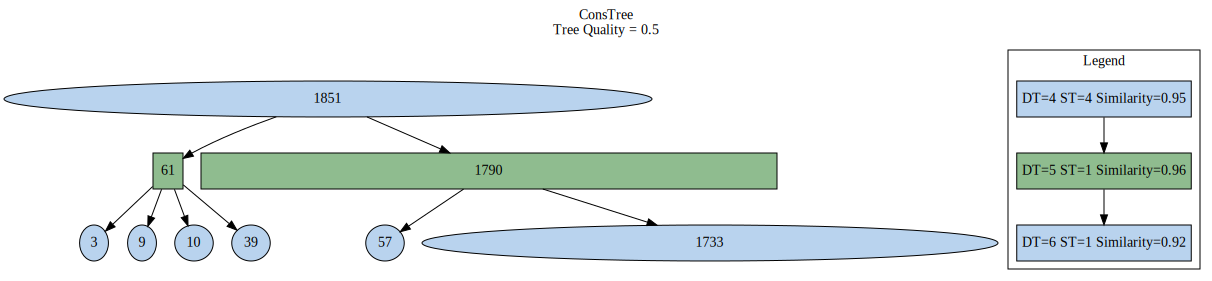

multicons  final_result
0          0.0                5
           1.0               56
1          0.0              774
           1.0             1016
dtype: int64

In [38]:
base_clusterings = [
    KMeans(
        n_clusters=3, max_iter=4000, n_init="auto", random_state=RANDOM_STATE
    ).fit_predict(feature_table),
    AgglomerativeClustering(n_clusters=3).fit_predict(feature_table),
    GaussianMixture(n_components=2, random_state=RANDOM_STATE).fit_predict(
        feature_table
    ),
    Birch(n_clusters=2, threshold=0.3).fit_predict(np.ascontiguousarray(feature_table)),
    DBSCAN(eps=0.7).fit_predict(feature_table),
    OPTICS(min_samples=100).fit_predict(feature_table),
]

# Searching for the best merging_threshold.
max_score = 0  # pylint: disable=invalid-name
merging_threshold = 0  # pylint: disable=invalid-name
# We reduce the search space for speed.
for mt in [0]:  # np.arange(0.0, 1, 0.25):
    recommended_consensus = MultiCons(
        consensus_function="consensus_function_12", merging_threshold=mt
    ).fit(base_clusterings)
    score = recommended_consensus.ensemble_similarity[recommended_consensus.recommended]
    if score > max_score:
        max_score = score
        merging_threshold = mt  # pylint: disable=invalid-name

display(
    f"MultiCons: selected merging_threshold={merging_threshold:0.2f} "
    f"with score: {max_score:0.2f}"
)

consensus = MultiCons(
    consensus_function="consensus_function_12", merging_threshold=merging_threshold
).fit(base_clusterings)

display(consensus.cons_tree())

pd.DataFrame(
    {"multicons": consensus.labels_, "final_result": result_table.final_result}
).groupby(["multicons", "final_result"]).size()

## Collaborative filtering

Next, for each consensus group we train a collaborative filtering model.

In [39]:
sim_options = {
    "name": ["msd"],  # ["msd", "cosine"],
    "min_support": [4],  # [3, 4, 5],
    "user_based": [False],  # [False, True],
}
param_grid = {"sim_options": sim_options, "verbose": [False]}

gs_recommenders = {}

for label in np.unique(consensus.labels_):
    display(f"label {label}")
    mask = consensus.labels_ == label
    sub_student_vle = student_item.loc[
        student_item.id_student.isin(result_table.loc[mask].index)
    ]
    reader = Reader(rating_scale=(0, sub_student_vle.sum_click.max()))
    data = Dataset.load_from_df(
        sub_student_vle[["id_student", "id_site", "sum_click"]], reader
    )

    gs = SupGridSearchCV(
        KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3, refit=True
    )
    gs.fit(data)

    display(gs.best_score["rmse"])
    display(gs.best_params["rmse"])
    gs_recommenders[label] = gs

'label 0'

232.2757621957072

{'sim_options': {'name': 'msd', 'min_support': 4, 'user_based': False},
 'verbose': False}

'label 1'

44.032273507303906

{'sim_options': {'name': 'msd', 'min_support': 4, 'user_based': False},
 'verbose': False}

## Recommendation

At this stage we generate recommedations for students that were predicted as failling.
We simulate students to follow N recommendations and measure whether it changes the
estimated success rate.

In [40]:
cluster_by_user = pd.Series(consensus.labels_, index=feature_table.index)
recommendation_improvement_rate_mc_cf = []
for recommendation_follow_count in range(1, 15):
    following_recommendation_students = []

    for one_failing_student_id in correct_failing_student_predictions.index:
        cluster_id = cluster_by_user.loc[one_failing_student_id]
        gs_recommender = gs_recommenders[cluster_id]
        site_ids = student_item.id_site.unique()
        prediction_actual = []
        for site_id in site_ids:
            prediction_actual.append(
                (
                    site_id,
                    int(gs_recommender.predict(one_failing_student_id, site_id).est),
                    feature_table.loc[one_failing_student_id, site_id],
                )
            )
        prediction_actual_df = pd.DataFrame(  # pylint: disable=invalid-name
            prediction_actual, columns=["site_id", "prediction", "actual"]
        ).set_index("site_id")

        # pylint: disable=unsubscriptable-object
        recommendations = prediction_actual_df[
            (prediction_actual_df.prediction != 0) & (prediction_actual_df.actual == 0)
        ].prediction.sort_values(ascending=False)[:recommendation_follow_count]

        new_student = feature_table.loc[[one_failing_student_id], :].copy()
        new_student.loc[:, recommendations.index] = recommendations.values
        following_recommendation_students.append(new_student.values[0])

    # following_recommendation_students[0]
    following_recommendation_students_df = pd.DataFrame(
        following_recommendation_students,
        columns=feature_table.columns,
        index=correct_failing_student_predictions.index,
    )

    final_result_predictions = gs_classifier.best_estimator_.predict(
        following_recommendation_students_df
    )

    recommendation_improvement_rate_mc_cf.append(
        (100 * final_result_predictions.sum() / final_result_predictions.size)
    )

recommendation_improvement_rate_mc_cf_df = pd.DataFrame(
    recommendation_improvement_rate_mc_cf,
    columns=["multicons_collaborative_filtering"],
    index=range(1, 15),
)
display(recommendation_improvement_rate_mc_cf_df)

,multicons_collaborative_filtering
1,0.826446
2,5.785124
3,14.876033
4,23.966942
5,35.537190
6,43.801653
7,52.892562
8,65.289256
9,69.421488
10,77.685950


## Validation

Finally, we compare the quality of our approach witha baseline method that applies
collaborative filtering on the full dataset.

In [41]:
reader = Reader(rating_scale=(0, student_item.sum_click.max()))
data = Dataset.load_from_df(
    student_item[["id_student", "id_site", "sum_click"]], reader
)

gs = SupGridSearchCV(
    KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3, refit=True
)
gs.fit(data)

display(gs.best_score["rmse"])
display(gs.best_params["rmse"])

101.9105342679817

{'sim_options': {'name': 'msd', 'min_support': 4, 'user_based': False},
 'verbose': False}

In [42]:
cluster_by_user = pd.Series(consensus.labels_, index=feature_table.index)
recommendation_improvement_rate_cf = []
for recommendation_follow_count in range(1, 15):
    following_recommendation_students = []

    for one_failing_student_id in correct_failing_student_predictions.index:
        site_ids = student_item.id_site.unique()
        prediction_actual = []
        for site_id in site_ids:
            prediction_actual.append(
                (
                    site_id,
                    int(gs.predict(one_failing_student_id, site_id).est),
                    feature_table.loc[one_failing_student_id, site_id],
                )
            )
        prediction_actual_df = pd.DataFrame(  # pylint: disable=invalid-name
            prediction_actual, columns=["site_id", "prediction", "actual"]
        ).set_index("site_id")

        # pylint: disable=unsubscriptable-object
        recommendations = prediction_actual_df[
            (prediction_actual_df.prediction != 0) & (prediction_actual_df.actual == 0)
        ].prediction.sort_values(ascending=False)[:recommendation_follow_count]

        new_student = feature_table.loc[[one_failing_student_id], :].copy()
        new_student.loc[:, recommendations.index] = recommendations.values
        following_recommendation_students.append(new_student.values[0])

    # following_recommendation_students[0]
    following_recommendation_students_df = pd.DataFrame(
        following_recommendation_students,
        columns=feature_table.columns,
        index=correct_failing_student_predictions.index,
    )

    final_result_predictions = gs_classifier.best_estimator_.predict(
        following_recommendation_students_df
    )

    recommendation_improvement_rate_cf.append(
        (100 * final_result_predictions.sum() / final_result_predictions.size)
    )

recommendation_improvement_rate_mc_cf_df[
    "collaborative_filtering"
] = recommendation_improvement_rate_cf
display(recommendation_improvement_rate_mc_cf_df)

,multicons_collaborative_filtering,collaborative_filtering
1,0.826446,0.826446
2,5.785124,4.132231
3,14.876033,10.743802
4,23.966942,22.314050
5,35.537190,28.925620
6,43.801653,41.322314
7,52.892562,52.066116
8,65.289256,64.462810
9,69.421488,72.727273
10,77.685950,76.859504


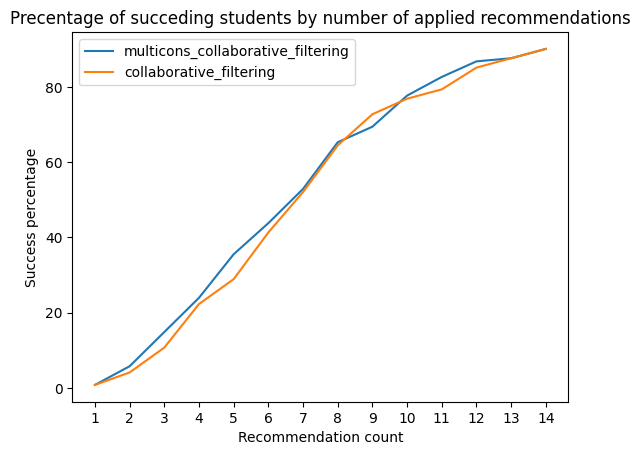

In [43]:
recommendation_improvement_rate_mc_cf_df.plot(
    title="Precentage of succeding students by number of applied recommendations",
    xlabel="Recommendation count",
    ylabel="Success percentage",
    xticks=recommendation_improvement_rate_mc_cf_df.index,
)
display()